# 1. Introduction
Machine learning is increasingly being used in high-stakes areas like criminal justice, where it can impact decisions such as bail or pretrial release. Tools like risk assessment models help predict if someone is likely to reoffend, but there's growing concern that these tools may reflect or worsen existing biases.

One well-known case is the COMPAS system, whose dataset has become a standard for testing fairness in predictions.

In this notebook, we explore how to detect and reduce three types of algorithmic bias such as disparate treatment, disparate impact, and disparate mistreatment using the COMPAS dataset. We also highlight the trade-offs between fairness and model accuracy during mitigation.

The complete notebook is available on GitHub: [https://github.com/zinia94/ai\_ethics\_assignment](https://github.com/zinia94/ai_ethics_assignment)


# 2. Business Problem Statement

As a Data Scientist at **Justice_AI**, a company specializing in AI-powered decision support tools for the criminal justice system, I am responsible for ensuring that our predictive models are not only accurate, but also equitable. One of our core products supports courts in assessing the risk of pretrial recidivism, that is, the likelihood that a defendant will reoffend if released before trial.

To evaluate and improve fairness in this domain, I have selected the widely used COMPAS dataset, which has been the subject of extensive scrutiny for its potential racial and gender biases. My objective is to audit this dataset for three critical types of discrimination:

1. **Disparate Treatment:** where the model uses sensitive attributes such as race or sex directly in decision-making.

2. **Disparate Impact:** where the outcomes of predictions disproportionately affect protected groups.

3. **Disparate Mistreatment:** where error rates such as false positives or false negatives are unevenly distributed across demographic groups.

This project will involve training baseline classifiers, quantifying bias using fairness metrics, and applying fairness-aware machine learning techniques to mitigate detected disparities. By doing so, I aim to develop a responsible risk assessment pipeline that aligns with both ethical standards and our company’s mission to promote fairer justice outcomes through technology.

# 3. Methodology

* **Dataset:** Used the [COMPAS dataset](https://github.com/propublica/compas-analysis) to assess pretrial recidivism risk.
* **Preprocessing:** Cleaned data, selected key features, derived `is_white` as the sensitive attribute, and split data using stratified sampling.
* **Models:** Trained three classifiers : Decision Tree (DT), Logistic Regression (LR), and Support Vector Classifier (SVC) , to establish baseline performance.
* **Fairness Evaluation:**

  * **Disparate Treatment:** Checked if predictions changed when flipping the sensitive attribute.
  * **Disparate Impact:** Compared negative outcome (favorable) rates and computed disparity ratios.
  * **Disparate Mistreatment:** Analyzed false positive and false negative rates across groups.

* **Mitigation Strategies:**

  * **Treatment:** Removed the sensitive attribute during training.
  * **Impact:** Applied reweighing to balance training data.
  * **Mistreatment:** Used threshold optimization to reduce error disparities.
* **Evaluation:** Compared fairness metrics before and after mitigation to assess improvement.


# 4. Install Required Libraries

In [1]:
!pip install fairlearn
!pip install matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 4.1 MB/s eta 0:00:00


# 5. Import necessary libraries

In [2]:
import pandas as pd
import numpy as np
import sklearn.model_selection as skms
import sklearn.compose
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from fairlearn.postprocessing import ThresholdOptimizer
import matplotlib.pyplot as plt
from IPython.display import Markdown
from sklearn.model_selection import train_test_split
import seaborn as sns

# 6. Define Reusable Functions

This section contains helper functions for tasks such as data loading, preprocessing and feature engineering, enabling reuse across different fairness analyses.



## 6.1 Function: Load COMPAS Dataset from URL

In [3]:
def load_compas_dataset():

    source_url = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"

    try:
        df = pd.read_csv(source_url)
        return df
    except Exception as e:
        print("Failed to load dataset:", e)
        return pd.DataFrame()  # Return empty DataFrame on failure


 ## 6.2 Function: Feature Engineering - Selection and Dataset Cleanup


This function prepares the COMPAS dataset for fairness-aware model training by selecting relevant, interpretable, and consistent features, while removing noisy or redundant ones.


**Selected Features and Rationale:**

* **`age`**: Binned into categories (young, adult, etc.) to reduce noise and support demographic-level fairness analysis.
* **`race`**(**`is_white`**): Transformed into a binary sensitive attribute for evaluating fairness between White and non-White groups.
* **`juv_fel_count`, `juv_misd_count`, `juv_other_count`**: Capture early criminal history, which can be predictive of future behavior.
* **`priors_count`**: A strong indicator of recidivism based on adult criminal history.
* **`c_charge_degree`**: Reflects the severity of the current offense.
* **`two_year_recid`**: Target variable indicating reoffending within two years.


**Excluded Features:**

Fields like names, IDs, dates, and assessment types were excluded because they are:

* Irrelevant (e.g., `screening_date`)
* Redundant or leaking future info (e.g., outcome-based fields)
* Inconsistent or incomplete across samples

The selected features strike a balance between predictive power and fairness analysis readiness.



In [5]:
def feature_selection_and_cleanup(df):

    df = df.copy()

    selected_columns = [
        'age',
        'race',
        'juv_fel_count',
        'juv_misd_count',
        'juv_other_count',
        'priors_count',
        'c_charge_degree',
        'two_year_recid'  # Target
    ]

    # Select and drop missing values
    df = df[selected_columns].dropna()

    # Bin age into categories
    df['age_group'] = pd.cut(
        df['age'],
        bins=[17, 25, 35, 60, df['age'].max()],
        labels=['young', 'adult', 'middle_aged', 'senior'],
        include_lowest=True
    )

    df.drop(columns=['age'], inplace=True)

    # Binary encoding: White vs. Non-White
    df['is_white'] = (df['race'] == 'Caucasian').astype(int)
    df.drop(columns=['race'], inplace=True)

    print("Selected Data Shape:", df.shape)
    print("Columns:", df.columns.tolist())

    return df

## 6.3 Function: Feature Engineering - Build Column Transformer

This function constructs and fits a ColumnTransformer to automate preprocessing. It standardizes numerical features using StandardScaler and one-hot encodes categorical features using OneHotEncoder. By identifying column types dynamically from the input DataFrame, the transformer ensures the preprocessing pipeline is adaptable and consistent across training and testing datasets.

In [8]:
def build_column_transformer(df):

    from sklearn.compose import ColumnTransformer
    from sklearn.preprocessing import StandardScaler, OneHotEncoder

    numerical_attributes = df.select_dtypes(include=["int64", "float64"]).columns.tolist()
    categorical_attributes = df.select_dtypes(include=["object"]).columns.tolist()

    print("Numerical attributes:", numerical_attributes)
    print("Categorical attributes:", categorical_attributes)

    ct = ColumnTransformer([
        ("standard_scaling", StandardScaler(), numerical_attributes),
        ("one_hot_encoding", OneHotEncoder(handle_unknown="ignore"), categorical_attributes)
    ])

    ct.fit(df)

    return ct

## 6.4 Function: Explore Dataset

This function displays the unique values in each column of the DataFrame to assist with initial data exploration and understanding feature distributions.

In [6]:
def explore_data(df):

    for col in df.columns:
        print(f"\n--- {col} ---")
        print(df[col].unique())

## 6.5 Function: Define Target, Sensitive and Non-Sensitive Feature Groups

This function identifies the target variable, sensitive attribute, and the set of non-sensitive features for fairness-aware model training.

In [7]:
def define_target_sensitive_and_non_sensitive_features(df):

    target_column = 'two_year_recid'
    sensitive_feature = 'is_white'

    non_sensitive_features = [
        feature for feature in df.columns
        if feature not in [sensitive_feature, target_column]
    ]

    print("Sensitive feature:", sensitive_feature)
    print("Non-sensitive features:", non_sensitive_features)

    return target_column, sensitive_feature, non_sensitive_features


## 6.6 Function: Fair Stratified Train-Test Split

Stratifies the dataset into balanced train and test sets based on both the sensitive attribute and target label to ensure fair representation.


In [39]:
def stratified_train_test_split(df, sensitive_feature, target_column, test_size=0.3, random_state=42, verbose=False):

    df_copy = df.copy()
    df_copy['stratify_col'] = df_copy[sensitive_feature].astype(str) + "_" + df_copy[target_column].astype(str)

    df_train, df_test = train_test_split(
        df_copy,
        test_size=test_size,
        random_state=random_state,
        stratify=df_copy['stratify_col']
    )

    df_train = df_train.drop(columns=['stratify_col'])
    df_test = df_test.drop(columns=['stratify_col'])

    if verbose:
        print("df_train size:", df_train.shape)
        print("df_test size:", df_test.shape)

    return df_train, df_test


## 6.7 Function: Full Data Preparation Pipeline (Load -> Clean -> Explore -> Define Features)

This function prepares the dataset by loading, cleaning, exploring, and defining key features for model training and fairness evaluation.

In [10]:
def prepare_data():

    df = load_compas_dataset()

    df = feature_selection_and_cleanup(df)
    explore_data(df)

    target_column, sensitive_feature, non_sensitive_features = define_target_sensitive_and_non_sensitive_features(df)

    return df, target_column, sensitive_feature, non_sensitive_features

# 7. Discrimination Discovery and Mitigation

This section investigates potential bias in model predictions by analyzing disparate treatment, disparate impact, and disparate mistreatment. It then applies mitigation strategies such as feature removal and sample reweighting to reduce unfairness while monitoring their effects on model performance and fairness metrics.


## 7.1. Disparity Treatment

Disparate treatment occurs when a predictive model or decision-making process gives different outcomes for individuals who are similar in all relevant aspects except for a protected attribute (such as race, gender, or age). Formally, it is present when:

$$
P(\hat{y} \mid x, z) \neq P(\hat{y} \mid x)
$$

Here:  
- $\hat{y}$ is the predicted outcome
- $x$ represents the non-sensitive features
- $z$ is the protected attribute






### 7.1.1. Discovery

In this section, we use model predictions to detect disparate treatment by comparing how individuals from different sensitive groups are classified under similar conditions, following a structured set of steps.

#### 7.1.1.1 Prepare Data

The predefined `prepare_data()` function is used to load the cleaned dataset, extract the target variable, identify the sensitive feature for fairness analysis, and define the non-sensitive features for modeling.


In [11]:
df, target_column, sensitive_feature, non_sensitive_features = prepare_data()

Selected Data Shape: (7214, 8)
Columns: ['juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count', 'c_charge_degree', 'two_year_recid', 'age_group', 'is_white']

--- juv_fel_count ---
[ 0  2  1  8  4  3  9 20  6  5 10]

--- juv_misd_count ---
[ 0  1  6 12  2  4  3  8  5 13]

--- juv_other_count ---
[ 0  1  2  3  4 17  9  5  6  7]

--- priors_count ---
[ 0  4  1  2 14  3  7  6  5 13  8  9 21 20 15 10 12 28 19 11 22 23 25 24
 36 18 16 33 17 30 27 38 26 37 29 35 31]

--- c_charge_degree ---
['F' 'M']

--- two_year_recid ---
[0 1]

--- age_group ---
['senior', 'adult', 'young', 'middle_aged']
Categories (4, object): ['young' < 'adult' < 'middle_aged' < 'senior']

--- is_white ---
[0 1]
Sensitive feature: is_white
Non-sensitive features: ['juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count', 'c_charge_degree', 'age_group']


#### 7.1.1.2 Group and Balance Similar Individuals for Disparate Treatment Analysis


Instead of using standard stratified splitting methods, I implemented a custom group-based balancing approach to support disparate treatment analysis, where similar individuals (based on non-sensitive features) should receive similar outcomes regardless of group membership.

By grouping data on non-sensitive attributes and ensuring that only groups with multiple sensitive subgroups are retained for testing, this method allows for meaningful fairness comparisons. Within each group, sensitive subgroups are balanced by size to avoid bias, and excluded records are used for training.

This targeted strategy ensures fair and interpretable evaluation of whether similar individuals are treated differently based on group membership.

In [12]:
grouped_df = df.groupby(non_sensitive_features, observed=False)

df_grouped = []
excluded_records = []

# Step 1: Group and handle cases with only one sensitive subgroup
for _, group_df in grouped_df:
    group_sensitives = list(group_df.groupby([sensitive_feature]))

    if len(group_sensitives) > 1:
        df_grouped.append(group_sensitives)
    else:
        # Only one subgroup — extract and store the DataFrame
        _, subgroup_df = group_sensitives[0]
        excluded_records.append(subgroup_df)

# Step 2: Balance remaining multi-subgroup groups
for i, group_list in enumerate(df_grouped):
    min_len = min(len(df_) for _, df_ in group_list)
    balanced_subgroups = []

    for key, subgroup_df in group_list:
        included = subgroup_df.iloc[:min_len]
        excluded = subgroup_df.iloc[min_len:]

        balanced_subgroups.append((key, included))

        if not excluded.empty:
            excluded_records.append(excluded)

    df_grouped[i] = balanced_subgroups

# Step 3: Combine excluded records
excluded_subgroups = pd.concat(excluded_records, ignore_index=True)

# Preview results
print("\nLength of df_grouped:", len(df_grouped))
print("Shape of excluded_subgroups:", excluded_subgroups.shape)



Length of df_grouped: 189
Shape of excluded_subgroups: (2640, 8)


#### 7.1.1.3 Finalize Train/Test Sets

This block assigns the fairness-evaluated training and test subsets, and prints their sizes along with a preview of the first few balanced test subgroups for verification.

In [17]:
df_train = excluded_subgroups
print("df_train size:", df_train.shape)

df_test_grouped = df_grouped
print("Number of grouped test subsets:", len(df_test_grouped))

print("\nShapes of the first few balanced test subgroups:")
for i, group_list in enumerate(df_test_grouped[:2]):
    print(f"  Group {i + 1}:")
    for sensitive_value, subgroup in group_list:
        print(f"    └ Subgroup '{sensitive_value}': {subgroup.shape}")


df_train size: (2640, 8)
Number of grouped test subsets: 189

Shapes of the first few balanced test subgroups:
  Group 1:
    └ Subgroup '(0,)': (109, 8)
    └ Subgroup '(1,)': (109, 8)
  Group 2:
    └ Subgroup '(0,)': (118, 8)
    └ Subgroup '(1,)': (118, 8)


#### 7.1.1.4 Data Preprocessing for Training

Training data is split into features (`x_train`) and target labels (`y_train`) for model training.


In [18]:
x_train = df_train.drop(columns=[target_column], axis= 1)
y_train = df_train[target_column]

print("x_train shape: ", x_train.shape)
print("y_train shape: ", y_train.shape)

x_train shape:  (2640, 7)
y_train shape:  (2640,)


#### 7.1.1.5 Feature Engineering: Training

A column transformer is applied to scale and encode `x_train`, preparing it for model training.


In [19]:
ct = build_column_transformer(x_train)
x_train = ct.transform(x_train)
print("Transformed x_train shape:", x_train.shape)

Numerical attributes: ['juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count', 'is_white']
Categorical attributes: ['c_charge_degree']
Transformed x_train shape: (2640, 7)


#### 7.1.1.6 Model Training

In this step, machine learning models are trained on the transformed training data to predict the target variable, enabling later evaluation of fairness across sensitive groups.


In [20]:
# @title ##### Decision Tree Classifier
dt_model = DecisionTreeClassifier(random_state=0, max_depth=5)
dt_model.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=5, random_state=0)

Train a Decision Tree classifier with a maximum depth of 5 on the training data.

In [21]:
# @title ##### Logistic Regression Classifier
lr_model = LogisticRegression(solver='liblinear')
lr_model.fit(x_train, y_train)

LogisticRegression(solver='liblinear')

A logistic regression model is trained using the `liblinear` solver, which is well-suited for smaller datasets and binary classification tasks. The model estimates the probability of the positive class based on a linear combination of input features.


In [22]:
# @title ##### SVC Classifier
svc_model = SVC(probability=True, random_state=42)
svc_model.fit(x_train, y_train)

SVC(probability=True, random_state=42)

An SVM (Support Vector Machine) classifier is trained with probability=True to enable probability estimates, which can be useful for fairness post-processing methods. The model attempts to find the optimal hyperplane that best separates the classes in the training data.

##### Register Trained Classifiers for Evaluation

A dictionary named `models` is created to store the trained classifiers (`DecisionTree`, `LogisticRegression`, and `SVC`) for easy iteration and evaluation in the subsequent fairness analysis steps.


In [23]:
models = {
    "dt": dt_model,
    "lr": lr_model,
    "svc": svc_model
}

#### 7.1.1.7 Disparity Treatment Discovery on Test Set

In this step, the test set is structured to evaluate disparate treatment by grouping individuals with identical non-sensitive attributes and observing how predictions differ across sensitive groups. This setup helps reveal whether similar individuals receive different outcomes solely due to group membership.

##### 7.1.1.7.1 Define Evaluation Functions

**Function: `evaluate_disparate_treatment_in_models`:**
This function assesses disparate treatment by testing if altering only the sensitive attribute (e.g., race) changes model predictions for individuals with otherwise identical features. It transforms both the original and flipped datasets, makes predictions using trained classifiers, and collects results for fairness evaluation. An optional `optimize_fairness` flag removes the sensitive feature entirely to simulate fairness-aware model testing.


In [24]:
def evaluate_disparate_treatment_in_models(models, df_test_grouped, optimize_fairness = False):

  classifiers_result = []

  for group_list in df_test_grouped:
      group_results = []

      for key, subgroup in group_list:
          group_label = key[0]

          current_df = subgroup.copy()
          x_test = current_df.drop([target_column], axis=1)
          y_test = current_df[target_column]

          x_test_flipped = x_test.copy()
          x_test_flipped[sensitive_feature] = x_test_flipped[sensitive_feature].apply(lambda x: 0 if x == 1 else 1)

          if optimize_fairness:
            x_test = x_test.drop([sensitive_feature],  axis=1)
            x_test_flipped = x_test_flipped.drop([sensitive_feature],  axis=1)

          transformed = ct.transform(x_test)
          transformed_flipped = ct.transform(x_test_flipped)

          result = {"group": group_label}

          for model_name, model in models.items():
              result[model_name] = model.predict(transformed)
              result[f"{model_name}_flipped"] = model.predict(transformed_flipped)

          group_results.append(result)

      classifiers_result.append(group_results)

  return classifiers_result

**Function: `summarize_disparate_treatment`:**
This function computes the overall flip rate for each classifier by aggregating the number of prediction changes observed after flipping the sensitive attribute across all test subgroups. A higher flip rate indicates a greater sensitivity of the model to the sensitive feature, highlighting potential disparate treatment. The output is a summary DataFrame showing flip rates per classifier.


In [25]:
def summarize_disparate_treatment(classifiers_result):
    flip_counts = {}
    total_counts = {}

    for group_results in classifiers_result:
        for result in group_results:
            for key in result:
                if key.endswith("_flipped"):
                    base_key = key.replace("_flipped", "")
                    y_pred = result[base_key]
                    y_pred_flipped = result[key]

                    flips = (y_pred != y_pred_flipped).sum()
                    total = len(y_pred)

                    flip_counts[base_key] = flip_counts.get(base_key, 0) + flips
                    total_counts[base_key] = total_counts.get(base_key, 0) + total

    flip_rates = {
        clf: flip_counts[clf] / total_counts[clf]
        for clf in flip_counts
    }

    return pd.DataFrame({
        'Classifier': list(flip_rates.keys()),
        'Flip Rate': list(flip_rates.values())
    })


**Function: `plot_aggregated_flip_rates`:**
This function visualizes the overall flip rates for each classifier using a bar chart. Flip rate represents the proportion of prediction changes after altering the sensitive attribute, providing an aggregated measure of disparate treatment. It helps compare model sensitivity to sensitive features at a glance.


In [26]:
def plot_aggregated_flip_rates(df_summary):

    plt.figure(figsize=(8, 5))
    bars = plt.bar(df_summary['Classifier'], df_summary['Flip Rate'], color='steelblue')

    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.005,
                 f"{height:.2%}", ha='center', va='bottom', fontsize=10)

    plt.ylabel("Flip Rate")
    plt.title("Disparate Treatment: Overall Flip Rate After Flipping Sensitive Attribute")
    plt.ylim(0, max(df_summary['Flip Rate']) + 0.05)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()


##### 7.1.1.7.2 Evaluate and Visualize (Original Models)

This block evaluates whether models treat similar individuals differently based on sensitive attributes by flipping the sensitive feature in the test data. It then summarizes the flip rates across classifiers and visualizes the aggregated results, helping identify the extent of disparate treatment present in model predictions.

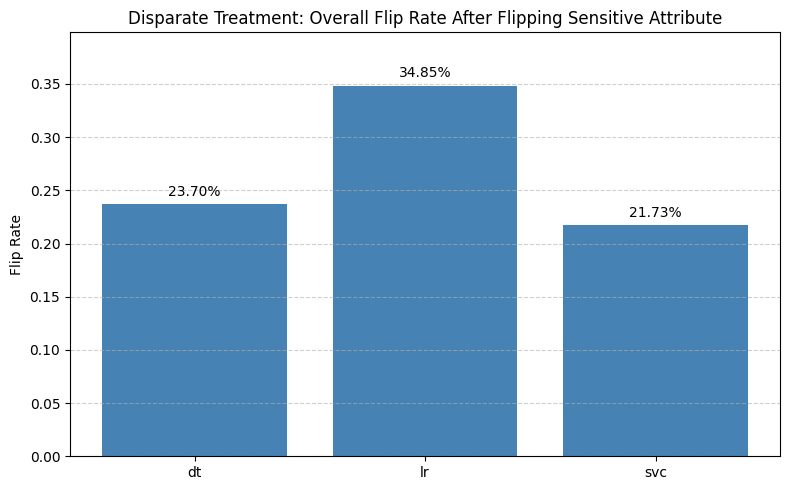

In [27]:
classifiers_result = evaluate_disparate_treatment_in_models(models, df_test_grouped)
aggregated_summary = summarize_disparate_treatment(classifiers_result)
plot_aggregated_flip_rates(aggregated_summary)

## 7.1.2 Mitigation via Preprocessing

In this section, a mitigation strategy is applied to address disparate treatment, where individuals with similar non-sensitive attributes may receive different outcomes based solely on the sensitive attribute. To reduce such unfairness, the sensitive feature is excluded during model testing, ensuring that the model predictions are not directly influenced by it. This helps assess whether fairness improves across sensitive groups without significantly sacrificing predictive performance.

#### 7.1.2.1 Data Preprocessing (Fair Training Set - Sensitive Feature Dropped)

The sensitive attribute is removed from the training data to prepare a fairness-aware dataset for model training.


In [29]:
df_train_fair = df_train.drop(columns=[sensitive_feature])
x_train_fair = df_train_fair.drop([target_column], axis= 1)
y_train_fair = df_train_fair[target_column]

print("df_train_fair shape", df_train_fair.shape)
print("x_train_fair size: ", x_train_fair.shape)
print("y_train_fair size: ", y_train_fair.shape)

df_train_fair shape (2640, 7)
x_train_fair size:  (2640, 6)
y_train_fair size:  (2640,)


#### 7.1.2.2 Feature Engineering: Fair Training Data

A column transformer is built and applied on the fairness-aware training data to scale and encode features before model training.

In [30]:
ct = build_column_transformer(x_train_fair)
x_train_fair = ct.transform(x_train_fair)
print("Transformed x_train shape:", x_train_fair.shape)

Numerical attributes: ['juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count']
Categorical attributes: ['c_charge_degree']
Transformed x_train shape: (2640, 6)


#### 7.1.2.3 Fair Model Training

In this section, classifiers are trained on fairness-aware data where the sensitive attribute has been removed, aiming to reduce disparate treatment.

In [31]:
# @title ##### Fair Decision Tree Classifier
dt_model_fair = DecisionTreeClassifier(random_state=0, max_depth=5)
dt_model_fair.fit(x_train_fair, y_train)

DecisionTreeClassifier(max_depth=5, random_state=0)

In [32]:
# @title ##### Fair Logistic Regression Classifier
lr_model_fair = LogisticRegression(solver='liblinear')
lr_model_fair.fit(x_train_fair, y_train)

LogisticRegression(solver='liblinear')

In [33]:
# @title ##### Fair SVC Classifier
svc_model_fair = SVC(probability=True, random_state=42)
svc_model_fair.fit(x_train_fair, y_train)

SVC(probability=True, random_state=42)

In [ ]:
# @title ##### Register Fair Trained Classifiers for Evaluation
fair_models = {
    "dt": dt_model_fair,
    "lr": lr_model_fair,
    "svc": svc_model_fair
}

#### 7.1.2.4 Evaluate and Visualize (Fair Models)

This section evaluates disparate treatment on the fair models trained without the sensitive attribute. It computes the flip rates after flipping the sensitive feature during model testing and visualizes them to observe treatment consistency across groups.

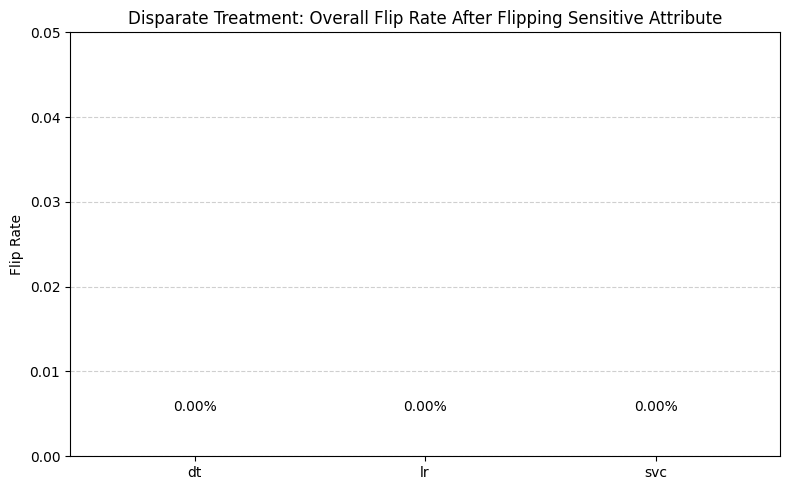

In [ ]:
fair_classifiers_result = evaluate_disparate_treatment_in_models(fair_models, df_test_grouped, optimize_fairness = True)
fair_aggregated_summary = summarize_disparate_treatment(fair_classifiers_result)
plot_aggregated_flip_rates(fair_aggregated_summary)


The comparison table shows a significant improvement in fairness after mitigation. All three classifiers, **Logistic Regression (lr)**, **Decision Tree (dt)**, and **Support Vector Classifier (svc)** reduced their flip rates to 0%, meaning that flipping the sensitive attribute no longer affects the prediction outcomes during testing.

This suggests that the mitigation strategy (removing the sensitive attribute during training and testing) was highly effective in eliminating **disparate treatment**, where similar individuals from different groups were previously being treated differently. The original flip rates **34.85%** for **lr**, **23.70%** for **dt**, and **21.73%** for **svc** indicated a substantial sensitivity to the race attribute. Reducing these to zero represents a strong improvement in fairness.


#### 7.1.2.5 Compare Flip Rates: Original vs Fair Models

This section compares flip rates of the original and fairness-mitigated models to evaluate improvements in treatment consistency. A merged summary table highlights the flip rate reduction for each classifier, with percentage improvements clearly shown for interpretability.

In [ ]:
# Merge original and fair summaries
comparison_df = aggregated_summary.merge(
    fair_aggregated_summary,
    on='Classifier',
    suffixes=('_Original', '_Fair')
)

# Compute improvement
comparison_df['Improvement'] = comparison_df['Flip Rate_Original'] - comparison_df['Flip Rate_Fair']

# Format and display
comparison_df = comparison_df.sort_values(by='Improvement', ascending=False)
comparison_df.style.format({
    'Flip Rate_Original': '{:.2%}',
    'Flip Rate_Fair': '{:.2%}',
    'Improvement': '{:.2%}'
}).set_caption("Comparison of Flip Rates Before and After Fairness Mitigation")

,Classifier,Flip Rate_Original,Flip Rate_Fair,Improvement
1,lr,34.85%,0.00%,34.85%
0,dt,23.70%,0.00%,23.70%
2,svc,21.73%,0.00%,21.73%


### 7.2. Disparate Impact

Disparate impact refers to **indirect discrimination**, where individuals from different protected groups (e.g., race, gender) receive different outcomes **even when the model does not explicitly use those attributes**. This typically occurs when the **ground-truth labels themselves are biased**, or when the model learns patterns from historically discriminatory data.

Disparate impact is present when the selection rate (i.e., the probability of receiving a positive outcome) differs between groups:

$$
P(\hat{y} = 1 \mid z = 0) \ne P(\hat{y} = 1 \mid z = 1)
$$

Where:

* $\hat{y}$ is the predicted outcome,
* $z$ is the protected attribute (e.g., race), with $z = 0$ for the unprivileged group and $z = 1$ for the privileged group.




### 7.2.1 Discovery

In this section, we identify potential disparate impact by calculating the disparity ratio between unprivileged and privileged groups. We use the 80% rule as a benchmark to flag models where prediction outcomes may unfairly disadvantage one group over another.

#### 7.2.1.1 Perpare Data

Load and prepare the dataset, returning the target, sensitive, and non-sensitive feature columns.


In [37]:
df, target_column, sensitive_feature, non_sensitive_features = prepare_data()

Selected Data Shape: (7214, 8)
Columns: ['juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count', 'c_charge_degree', 'two_year_recid', 'age_group', 'is_white']

--- juv_fel_count ---
[ 0  2  1  8  4  3  9 20  6  5 10]

--- juv_misd_count ---
[ 0  1  6 12  2  4  3  8  5 13]

--- juv_other_count ---
[ 0  1  2  3  4 17  9  5  6  7]

--- priors_count ---
[ 0  4  1  2 14  3  7  6  5 13  8  9 21 20 15 10 12 28 19 11 22 23 25 24
 36 18 16 33 17 30 27 38 26 37 29 35 31]

--- c_charge_degree ---
['F' 'M']

--- two_year_recid ---
[0 1]

--- age_group ---
['senior', 'adult', 'young', 'middle_aged']
Categories (4, object): ['young' < 'adult' < 'middle_aged' < 'senior']

--- is_white ---
[0 1]
Sensitive feature: is_white
Non-sensitive features: ['juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count', 'c_charge_degree', 'age_group']


#### 7.2.1.2 Train Test Split (Stratified)

Split the dataset into training and test sets with stratification on the sensitive attribute and target to ensure balanced group representation.


In [45]:
df_train, df_test = stratified_train_test_split(df, sensitive_feature, target_column)

print("df_train shape: ", df_train.shape)
print("df_test Shape: ", df_test.shape)

df_train shape:  (5049, 8)
df_test Shape:  (2165, 8)


#### 7.2.1.3 Data Preprocessing

Separate the training and test sets into features (`x_train`, `x_test`) and labels (`y_train`, `y_test`) for model development and evaluation.


In [46]:
x_train = df_train.drop([target_column], axis= 1)
y_train = df_train[target_column]
x_test = df_test.drop([target_column], axis= 1)
y_test = df_test[target_column]

print("x_train size: ", x_train.shape)
print("y_train size: ", y_train.shape)
print("x_test size: ", x_test.shape)
print("y_test size: ", y_test.shape)

x_train size:  (5049, 7)
y_train size:  (5049,)
x_test size:  (2165, 7)
y_test size:  (2165,)


#### 7.2.1.4 Group-Specific Test Sets by Sensitive Feature

Split the test set into two groups **white** and **non-white** based on the sensitive attribute to enable group-wise fairness analysis.


In [47]:
x_test_white = x_test[x_test[sensitive_feature] == 1]
x_test_non_white = x_test[x_test[sensitive_feature] == 0]

x_test_grouped = {
    'white': x_test_white,
    'non_white': x_test_non_white
}

#### 7.2.1.5 Feature Engineering

Transform both the training and grouped test sets using the fitted column transformer to ensure consistent preprocessing for fairness evaluation.


In [48]:
ct = build_column_transformer(x_train)

x_train = ct.transform(x_train)

for group, group_df in x_test_grouped.items():
  x_test_grouped[group] = ct.transform(group_df)

print("x_train size: ", x_train.shape)

for group, group_df in x_test_grouped.items():
  print(f"x_test_{group} size: ", group_df.shape)

Numerical attributes: ['juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count', 'is_white']
Categorical attributes: ['c_charge_degree']
x_train size:  (5049, 7)
x_test_white size:  (736, 7)
x_test_non_white size:  (1429, 7)


#### 7.2.1.6 Model Training

Train classification models on the original dataset (including the sensitive attribute) to later evaluate disparities in their predictions across different sensitive groups.

In [54]:
# @title ##### Decision Tree Classifier
dt_model = DecisionTreeClassifier(random_state=0, max_depth=5)
dt_model.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=5, random_state=0)

In [89]:
# @title ##### Logistic Regression Classifier
lr_model = LogisticRegression(solver='liblinear')
lr_model.fit(x_train, y_train)

LogisticRegression(solver='liblinear')

In [56]:
# @title ##### SVC Classifier
svc_model = SVC(probability=True, random_state=42)
svc_model.fit(x_train, y_train)

SVC(probability=True, random_state=42)

In [57]:
# @title ##### Register Trained Classifier for Evaluation
models = {
    "dt": dt_model,
    "lr": lr_model,
    "svc": svc_model
}

#### 7.2.1.7 Disparity Impact Discovery on Test Set

This step evaluates whether the trained models produce different negative prediction rates (favorable) for privileged and unprivileged groups

##### 7.2.1.7.1 Define Evaluation Functions


**Function: `evaluate_disparate_impact_in_models`**

This function assesses **disparate impact** by evaluating trained machine learning models separately on different subgroups of the test set (e.g., White vs. Non-White). Each subgroup is defined by a sensitive attribute such as race. The function iterates through all groups and models, collects predictions, and returns a list of results containing predicted labels and group metadata. This allows for further analysis of whether models produce unequal negative outcome rates across groups, which is key to identifying potential indirect discrimination.


In [84]:
def evaluate_disparate_impact_in_models(models, x_test_grouped):

    results = []

    for group_name, group_df in x_test_grouped.items():
        result = {
            'group': group_name,
            'shape': group_df.shape
        }

        for model_name, model in models.items():
            try:
                result[model_name] = model.predict(group_df)
            except Exception as e:
                print(f"Error predicting with {model_name} on group {group_name}: {e}")
                result[model_name] = None

        results.append(result)

    return results


**Function: `summarize_disparate_impact`**

This function summarizes model performance across sensitive groups by reporting the number and percentage of **favorable predictions** (i.e., predicted label = 0) made by each classifier. In the COMPAS dataset, a label of `0` represents a **low risk** outcome (i.e., the individual is predicted not to reoffend), which is considered **favorable**.

It processes the output from the disparate impact evaluation step and creates a structured DataFrame that includes:

* The sensitive group label (e.g., White or Non-White)
* The classifier name
* The number of records evaluated per group
* The number and percentage of favorable predictions

After compiling these metrics, the function calculates the **disparity ratio** for each classifier using the following formula:

$$
\text{Disparity Ratio} = \frac{\text{Favorable Rate (Non-White)}}{\text{Favorable Rate (White)}}
$$

A disparity ratio close to **1.0** suggests fairness, indicating that both groups receive favorable outcomes at similar rates. A **lower ratio** (especially below 0.8) may indicate **indirect discrimination** or **disparate impact** against the non-white group. This summary is key to detecting and quantifying fairness issues in model predictions.



In [85]:
def summarize_disparate_impact(models, classifiers_result):

    summary_rows = []

    # Step 1: Aggregate basic metrics
    for entry in classifiers_result:
        group = entry['group']
        total = entry['shape'][0]

        for model_name in models:
            predictions = entry[model_name]
            negative = np.sum(predictions == 0)
            percentage = (negative / total) * 100 if total > 0 else 0

            summary_rows.append({
                "group": group,
                "classifier": model_name,
                "total_records": total,
                "negative_results": negative,
                "negative_percentage (%)": round(percentage, 2)
            })

    summary_df = pd.DataFrame(summary_rows)

    # Step 2: Compute disparity ratios
    def compute_disparity_ratio(df_group):
        if set(df_group['group']) != {'white', 'non_white'}:
            df_group['disparity_ratio'] = None
            return df_group

        white_pct = df_group[df_group['group'] == 'white']["negative_percentage (%)"].values[0]
        non_white_pct = df_group[df_group['group'] == 'non_white']["negative_percentage (%)"].values[0]

        ratio = round(non_white_pct / white_pct, 4) if white_pct != 0 else None
        df_group['disparity_ratio'] = ratio
        return df_group

    grouped_results = []

    for _, group in summary_df.groupby('classifier', group_keys=False):
        result = compute_disparity_ratio(group.copy())
        grouped_results.append(result)

    summary_df = pd.concat(grouped_results, ignore_index=True)

    return summary_df


**Function: `plot_disparity_ratios`**

This function visualizes the disparity ratio for each classifier using a bar plot. A red dashed line at 0.8 highlights the "80% rule" threshold, helping identify models with potential disparate impact across groups.

In [86]:
def plot_disparity_ratios(summary_df):
    """
    Plot disparity ratio per classifier from disparate impact summary.

    Parameters:
        summary_df (pd.DataFrame): Output of summarize_disparate_impact
    """
    plt.figure(figsize=(8, 5))
    disparity_df = summary_df.drop_duplicates(subset=['classifier'])  # only once per classifier

    sns.barplot(
        data=disparity_df,
        x="classifier",
        y="disparity_ratio"
    )
    plt.axhline(y=0.8, color='red', linestyle='--', label='80% Threshold')
    plt.title("Disparity Ratio per Classifier")
    plt.ylabel("Disparity Ratio (min / max selection rate)")
    plt.ylim(0, 1.05)
    plt.legend()
    plt.tight_layout()
    plt.show()


**Function: `pivot_disparate_impact_summary`**

This function creates a **pivot table** to display the percentage of negative predictions for each sensitive group (e.g., white vs. non-white) across different classifiers. The table uses classifiers as rows and groups as columns, with values showing the **negative prediction rate**. This format allows for easy side-by-side comparison of group-wise outcomes, aiding in the identification of **disparate impact** across models.


In [87]:
def pivot_disparate_impact_summary(summary_df):

    disparity_values = summary_df.drop_duplicates(subset=['classifier'])[['classifier', 'disparity_ratio']].set_index('classifier')

    pivot = summary_df.pivot_table(
        index="classifier",
        columns="group",
        values="negative_percentage (%)"
    )

    # Add disparity ratio
    pivot = pivot.join(disparity_values)


    display(Markdown("### Negative Prediction Percentages by Classifier and Group"))
    display(pivot.round(2))


##### 7.2.1.7.2 Evaluate and Visualize (Original Models)

Performs disparate impact analysis by evaluating models on sensitive groups, summarizing favorable outcome rates, computing disparity ratios, and visualizing the results.


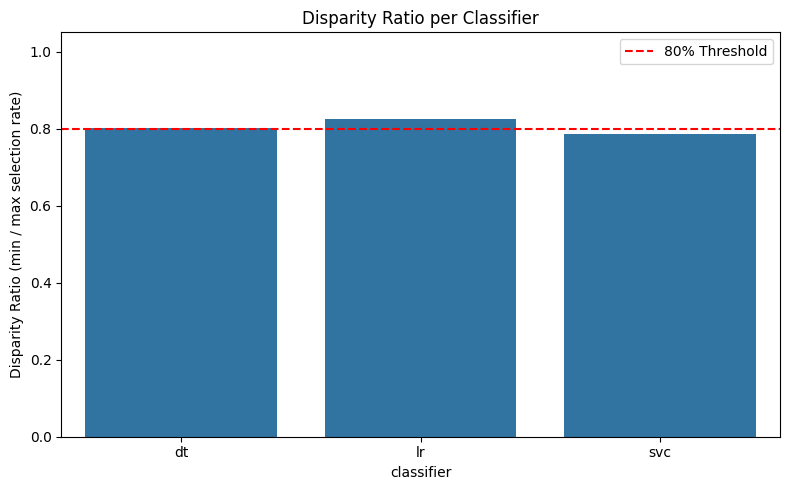

### Negative Prediction Percentages by Classifier and Group

,non_white,white,disparity_ratio
classifier,,,
dt,53.11,66.17,0.80
lr,68.79,83.29,0.83
svc,64.87,82.61,0.79


In [88]:
classifiers_result = evaluate_disparate_impact_in_models(models, x_test_grouped)
summary_df = summarize_disparate_impact(models, classifiers_result)
plot_disparity_ratios(summary_df)
pivot_disparate_impact_summary(summary_df)

This table summarizes the **proportion of favorable predictions** (i.e., predicted as `0`, which means not likely to reoffend in the COMPAS dataset) made by each classifier for the **non-white** and **white** groups.

* For all classifiers (`dt`, `lr`, `svc`), the **white group consistently receives more favorable predictions** than the non-white group.

* The **disparity ratio** (Non-White Rate / White Rate) ranges from **0.79 to 0.83**, indicating that non-white individuals are **less likely to be predicted as low risk**, compared to white individuals.

* Two of the three classifiers (DT and SVC) fall at or below the 0.80 "80% rule" threshold, indicating potential disparate impact, while LR slightly exceeds the threshold at 0.83


These results suggest that the models may exhibit **indirect discrimination** against the non-white group, as they are systematically less likely to receive favorable outcomes. While the disparity is not extreme, it is **consistent and quantifiable** across all classifiers.



### 7.2.2 Mitigation via Preprocessing

In this section, we address disparate impact through a reweighting approach. Instead of removing the sensitive attribute, we assign different weights to training instances based on their group membership and label to balance the representation of favorable and unfavorable outcomes across sensitive groups. This method aims to mitigate indirect bias by making the training distribution more equitable. After training models on the reweighted dataset, we evaluate them using group-specific test data to observe whether the disparity in favorable outcomes has decreased, indicating improved fairness.

#### 7.2.2.1 Compute Sample Weights to Balance Groups

This code calculates instance-level weights to balance the joint distribution of the sensitive attribute and target label in the training dataset. It starts by counting the number of samples in each (sensitive_feature, target) combination and then computes a uniform desired count. Weights are then assigned inversely proportional to each group’s representation to ensure underrepresented combinations receive higher importance during training. These weights are extracted into a NumPy array sample_weights, which can be passed to model training to mitigate disparate impact.

In [90]:
# Compute weights to balance groups
print("df_train shape : ",df_train.shape)

group_counts = df_train.groupby([sensitive_feature, target_column]).size()
total = group_counts.sum()
desired = total / len(group_counts)

# Create weight mapping
weights = group_counts.copy().astype(float)
for idx in weights.index:
    weights[idx] = desired / group_counts[idx]

# Assign weights to each row
def get_weight(row):
    return weights[(row[sensitive_feature], row[target_column])]

sample_weights = df_train.apply(get_weight, axis=1).values

sample_weights

df_train shape :  (5049, 8)


array([0.72878176, 0.72878176, 0.72878176, ..., 0.78939962, 1.86723373,
       1.21137236])

#### 7.2.2.2 Train Models Using Weights

Train models using sample weights to mitigate bias during learning and promote fairer outcomes across sensitive groups.

In [91]:
# @title ##### Decision Tree Classifier
dt_model_fair = DecisionTreeClassifier(random_state=0,max_depth=5)
dt_model_fair.fit(x_train, y_train, sample_weight=sample_weights)

DecisionTreeClassifier(max_depth=5, random_state=0)

In [92]:
# @title ##### Logistic Regression Classifier
lr_model_fair = LogisticRegression(solver='liblinear')  # 'liblinear' supports sample_weight
lr_model_fair.fit(x_train, y_train, sample_weight=sample_weights)

LogisticRegression(solver='liblinear')

In [93]:
# @title ##### SVC Classifier
svc_model_fair = SVC(probability=True, random_state=42)
svc_model_fair.fit(x_train, y_train, sample_weight=sample_weights)

SVC(probability=True, random_state=42)

In [94]:
# @title ##### Register Fair Trained Classifier for Evaluation
fair_models = {
    "dt": dt_model_fair,
    "lr": lr_model_fair,
    "svc": svc_model_fair
}

#### 7.2.2.3 Evaluate and Visualize (Fair models)

This step evaluates the fairness-mitigated models on the test set to assess their performance across sensitive groups. It summarizes group-wise prediction outcomes, computes updated disparity ratios, and visualizes the impact of mitigation on fairness through plots and pivot tables.

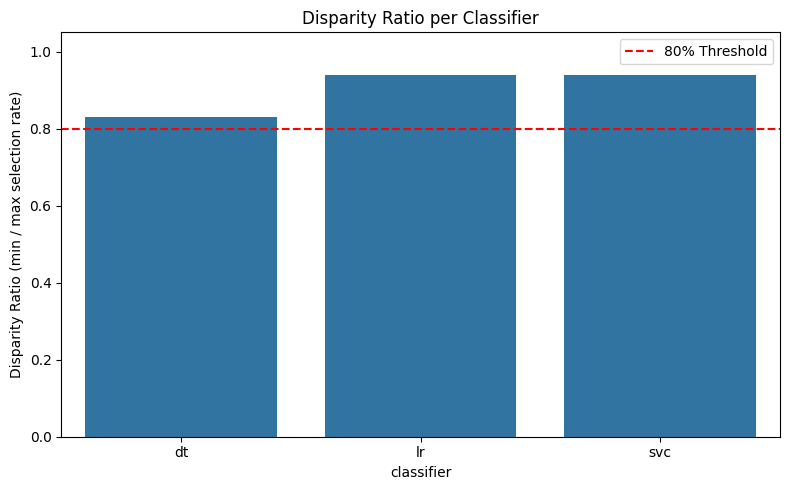

### Negative Prediction Percentages by Classifier and Group

,non_white,white,disparity_ratio
classifier,,,
dt,52.97,63.86,0.83
lr,63.89,67.93,0.94
svc,61.09,65.08,0.94


In [95]:
fair_classifiers_result = evaluate_disparate_impact_in_models(fair_models, x_test_grouped)
fair_summary_df = summarize_disparate_impact(fair_models, fair_classifiers_result)
plot_disparity_ratios(fair_summary_df)
pivot_disparate_impact_summary(fair_summary_df)

#### 7.2.2.4 Compare Disparate Impact (Disparity Ratio) Before and After Mitigation

This block compares group-wise fairness metrics before and after applying mitigation. It works by:

1. Extracting the negative outcome percentages (unfavorable outcomes) and **disparity ratios** for each classifier using a consistent prefix (`before` or `after`).
2. Merging the two summaries to align the results.
3. Calculating the improvement in disparity ratio (how much closer the model became to fairness after mitigation).
4. Formatting the values for clearer comparison.

The final `comparison_df` provides a side-by-side view of how each classifier’s fairness metrics changed, helping quantify the effectiveness of the mitigation technique.


In [96]:
def extract_disparity_data(summary_df, prefix):

    pivot = summary_df.pivot(index='classifier', columns='group', values='negative_percentage (%)').reset_index()
    disparity = summary_df[['classifier', 'disparity_ratio']].drop_duplicates(subset='classifier')
    result = pd.merge(pivot, disparity, on='classifier')

    # Rename group columns with prefix (e.g., 'white' -> 'white_before')
    renamed = {
        group: f"{group}_{prefix}"
        for group in result.columns if group not in ['classifier', 'disparity_ratio']
    }
    renamed['disparity_ratio'] = f"disparity_ratio_{prefix}"

    return result.rename(columns=renamed)

before_df = extract_disparity_data(summary_df, prefix="before")
after_df = extract_disparity_data(fair_summary_df, prefix="after")

# Merge and calculate improvement
comparison_df = pd.merge(before_df, after_df, on='classifier', how='inner')
comparison_df['improvement'] = (comparison_df['disparity_ratio_after'] - comparison_df['disparity_ratio_before']).round(4)

# Optional: round
cols_to_round = [col for col in comparison_df.columns if col != 'classifier']
comparison_df[cols_to_round] = comparison_df[cols_to_round].round(2)

comparison_df["improvement"] = comparison_df["improvement"].apply(
    lambda x: f"+{x:.2f}" if x > 0 else f"{x:.2f}"
)

display(comparison_df)

,classifier,non_white_before,white_before,disparity_ratio_before,non_white_after,white_after,disparity_ratio_after,improvement
0,dt,53.11,66.17,0.80,52.97,63.86,0.83,+0.03
1,lr,68.79,83.29,0.83,63.89,67.93,0.94,+0.11
2,svc,64.87,82.61,0.79,61.09,65.08,0.94,+0.15


This table highlights how reweighting helped mitigate disparate impact across three classifiers:

* **Before mitigation**, all models had disparity ratios below 0.85, indicating non-white individuals were more likely to receive negative outcomes.
* **After reweighting**, disparity ratios improved across the board:

  * SVC and Logistic Regression showed strong gains (+0.15 and +0.11), nearing the fairness ideal of 1.0.
  * Decision Tree improved slightly (+0.03), suggesting limited sensitivity to weighting.

Reweighting effectively reduced bias, especially for linear and margin-based models, but decision trees may require additional fairness strategies.


## 7.3 Disparate Mistreatment

Disparate mistreatment occurs when a model exhibits different error rates across protected groups, even when the ground truth labels are assumed to be unbiased. It reflects indirect discrimination, where individuals from different groups receive unequal treatment due to imbalanced prediction errors, such as false positives or false negatives.

Formally, it can be expressed as:

$$
P(\hat{y} \ne y \mid z = 0) \ne P(\hat{y} \ne y \mid z = 1)
$$

Where:

* $\hat{y}$ is the model's prediction,
* $y$ is the true label,
* $z$ is the sensitive attribute (e.g., race or gender).

This disparity reveals whether the model's accuracy or error is unfairly distributed. Even if the overall accuracy is high, a significant difference in error rates between groups can indicate algorithmic bias that needs to be addressed.


### 7.3.1 Discovery

This section investigates whether the model makes unequal errors across different sensitive groups (e.g., White vs. Non-White). Specifically, it evaluates if the prediction error rate (i.e., the proportion of incorrect predictions) is significantly different between groups, even when the ground truth is assumed to be fair.

For each classifier, predictions are compared against true labels in the test set, and the overall error rate is computed separately for each group:

$$
P(\hat{y} \ne y \mid z = 0) \quad \text{vs.} \quad P(\hat{y} \ne y \mid z = 1)
$$

A large difference in error rates signals disparate mistreatment, suggesting that one group is disproportionately affected by incorrect model decisions. This analysis is crucial for uncovering fairness issues beyond accuracy, especially when misclassifications have real-world consequences.


#### 7.3.1.1 Prepare Data

The dataset is prepared and relevant columns such as target, sensitive, and non-sensitive features are extracted for further fairness analysis.

In [100]:
df, target_column, sensitive_feature, non_sensitive_features = prepare_data()

Selected Data Shape: (7214, 8)
Columns: ['juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count', 'c_charge_degree', 'two_year_recid', 'age_group', 'is_white']

--- juv_fel_count ---
[ 0  2  1  8  4  3  9 20  6  5 10]

--- juv_misd_count ---
[ 0  1  6 12  2  4  3  8  5 13]

--- juv_other_count ---
[ 0  1  2  3  4 17  9  5  6  7]

--- priors_count ---
[ 0  4  1  2 14  3  7  6  5 13  8  9 21 20 15 10 12 28 19 11 22 23 25 24
 36 18 16 33 17 30 27 38 26 37 29 35 31]

--- c_charge_degree ---
['F' 'M']

--- two_year_recid ---
[0 1]

--- age_group ---
['senior', 'adult', 'young', 'middle_aged']
Categories (4, object): ['young' < 'adult' < 'middle_aged' < 'senior']

--- is_white ---
[0 1]
Sensitive feature: is_white
Non-sensitive features: ['juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count', 'c_charge_degree', 'age_group']


#### 7.3.1.2 Train Test Split (Stratified)

The dataset is split into training and testing sets using stratification to preserve the distribution of both the sensitive attribute and the target variable.

In [101]:
df_train, df_test = stratified_train_test_split(df, sensitive_feature, target_column)

print("df_train shape: ", df_train.shape)
print("df_test Shape: ", df_test.shape)

df_train shape:  (5049, 8)
df_test Shape:  (2165, 8)


#### 7.3.1.3 Group-Specific Test Sets by Sensitive Feature

The test set is divided into two subsets based on the sensitive attribute to allow group-wise evaluation of model errors.


In [102]:
x_test_white = df_test[df_test[sensitive_feature] == 1]
x_test_non_white = df_test[df_test[sensitive_feature] == 0]

test = {
    'white': x_test_white,
    'non_white': x_test_non_white
}

#### 7.3.1.4 Data Preprocessing: Training Data

This step prepares the training and group-wise test datasets by splitting features and labels. It also extracts the sensitive attribute separately for each group to support error analysis by subgroup.


In [103]:
x_train = df_train.drop([target_column], axis= 1)
y_train = df_train[target_column]

sensitive_train_group = x_train[sensitive_feature]

for group, df_group in test.items():
  test[group] = {
      'x': df_group.drop([target_column], axis= 1),
      'y': df_group[target_column],
      'sensitive_group': df_group[sensitive_feature]
  }

print("x_train size: ", x_train.shape)
print("y_train size: ", y_train.shape)

for group, df_group in test.items():
  for key, value in df_group.items():
    print(f"{group} {key}_test size: ", value.shape)

x_train size:  (5049, 7)
y_train size:  (5049,)
white x_test size:  (736, 7)
white y_test size:  (736,)
white sensitive_group_test size:  (736,)
non_white x_test size:  (1429, 7)
non_white y_test size:  (1429,)
non_white sensitive_group_test size:  (1429,)


#### 7.3.1.5 Feature Engineering

This section applies a fitted column transformer to scale and encode the training features and each group's test features. It ensures that both training and test sets are processed consistently for fair evaluation.

In [104]:
ct = build_column_transformer(x_train)

x_train = ct.transform(x_train)

for group, df_group in test.items():
  for key, value in df_group.items():
    if key == 'x':
      test[group][key] = ct.transform(value)


print("x_train size: ", x_train.shape)
print("y_train size: ", y_train.shape)

for group, df_group in test.items():
  for key, value in df_group.items():
    print(f"{group} {key}_test size: ", value.shape)

Numerical attributes: ['juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count', 'is_white']
Categorical attributes: ['c_charge_degree']
x_train size:  (5049, 7)
y_train size:  (5049,)
white x_test size:  (736, 7)
white y_test size:  (736,)
white sensitive_group_test size:  (736,)
non_white x_test size:  (1429, 7)
non_white y_test size:  (1429,)
non_white sensitive_group_test size:  (1429,)


#### 7.3.1.6 Model Training

This section trains machine learning models (e.g., Decision Tree, Logistic Regression, SVM) on the preprocessed training data, enabling performance and fairness evaluation in subsequent analysis.

In [105]:
# @title ##### Decision Tree Classifier
dt_model = DecisionTreeClassifier(random_state=0, max_depth=5)
dt_model.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=5, random_state=0)

In [106]:
# @title ##### Logistic Regression Classifier
lr_model = LogisticRegression(solver='liblinear')
lr_model.fit(x_train, y_train)

LogisticRegression(solver='liblinear')

In [108]:
# @title ##### SVC Classifier
svc_model = SVC(probability=True, random_state=42)
svc_model.fit(x_train, y_train)

SVC(probability=True, random_state=42)

In [109]:
# @title ##### Register Trained Classifiers for Evaluation

models = {
    "dt": dt_model,
    "lr": lr_model,
    "svc": svc_model
}

#### 7.3.2.7 Disparity Mistreatment Discovery on Test Set


This section evaluates **disparate mistreatment** by comparing model misclassification rates (i.e., incorrect predictions) across sensitive groups. Specifically, it checks whether the likelihood of making a wrong prediction differs between groups (e.g., White vs. Non-White), even when the ground truth labels are assumed to be unbiased. This helps uncover indirect discrimination through unequal error rates.


##### 7.3.2.7.1 Define Evaluation Functions

**Function: `evaluate_models_for_disparate_mistreatment`**

This function analyzes model performance across sensitive groups by calculating error rate, false positive rate (FPR), and false negative rate (FNR). It highlights disparities in misclassification patterns—especially important when ground truth labels are assumed fair. If `post_processing=True`, the model is evaluated using group-sensitive predictions (e.g., fairness-aware models). The output is a list of dictionaries summarizing each model’s performance per group.


In [110]:
def evaluate_models_for_disparate_mistreatment(models, post_processing=False):

    results = []

    for group, df_group in test.items():
        result = {'group': group, 'shape': df_group['x'].shape}

        for model_name, model in models.items():
            y_true = df_group['y']

            # Predict based on whether model needs sensitive feature
            if post_processing:
                y_pred = model.predict(df_group['x'], sensitive_features=df_group['sensitive_group'])
            else:
                y_pred = model.predict(df_group['x'])

            tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

            accuracy = (tp + tn) / (tp + tn + fp + fn)
            error_rate = 1 - accuracy
            fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
            fnr = fn / (fn + tp) if (fn + tp) > 0 else 0

            result[f"{model_name}_accuracy"] = round(accuracy, 4)
            result[f"{model_name}_error"] = round(error_rate, 4)
            result[f"{model_name}_fpr"] = round(fpr, 4)
            result[f"{model_name}_fnr"] = round(fnr, 4)

        results.append(result)

    return results


**Function: `get_summary_of_disparate_mistreatment_evaluation`**

This function compiles the group-wise performance metrics from disparate mistreatment evaluation into a structured summary DataFrame. For each model and sensitive group, it reports accuracy, error rate, false positive rate (FPR), and false negative rate (FNR) as percentages. The resulting table enables easy comparison of classification disparities between groups.


In [111]:
def get_summary_of_disparate_mistreatment_evaluation(models, results):

    summary_rows = []

    for entry in results:
        group = entry['group']
        total = entry['shape'][0]

        for model_name in models.keys():
            summary_rows.append({
                "group": group,
                "classifier": model_name,  # keep lowercase for consistency if already used like this
                "total_records": total,
                "accuracy (%)": round(entry[f"{model_name}_accuracy"] * 100, 2),
                "error_rate (%)": round(entry[f"{model_name}_error"] * 100, 2),
                "false_positive_rate (%)": round(entry[f"{model_name}_fpr"] * 100, 2),
                "false_negative_rate (%)": round(entry[f"{model_name}_fnr"] * 100, 2)
            })

    summary_df = pd.DataFrame(summary_rows)
    return summary_df


**Function: `plot_disparate_mistreatment_summary`**

This function visualizes group-wise disparities in false positive rates (FPR) and false negative rates (FNR) for each classifier. It plots side-by-side bar charts for each group and metric, enabling intuitive comparison of classification errors across sensitive groups and models to reveal patterns of mistreatment.


In [112]:
def plot_disparate_mistreatment_summary(results):

    # Convert results to DataFrame
    df = pd.DataFrame(results)

    # Extract model names from keys like 'lr_fpr'
    model_names = sorted({key.split('_')[0] for key in df.columns if key.endswith('_fpr')})

    for metric in ['fpr', 'fnr']:
        fig, ax = plt.subplots(figsize=(10, 5))
        width = 0.2
        x = range(len(df))

        for i, model in enumerate(model_names):
            bars = ax.bar(
                [pos + i * width for pos in x],
                df[f"{model}_{metric}"],
                width=width,
                label=model.upper()
            )

        ax.set_xticks([pos + width for pos in x])
        ax.set_xticklabels(df['group'])
        ax.set_ylabel(metric.upper())
        ax.set_title(f"{metric.upper()} Comparison Across Groups")
        ax.legend()
        ax.grid(True, linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.show()


##### 7.3.2.7.2 Evaluate and Visualize (Original Models)

This section evaluates **disparate mistreatment** by computing and visualizing key error metrics—**error rate**, **false positive rate (FPR)**, and **false negative rate (FNR)**—for each sensitive group across all trained classifiers. The results help identify whether one group is unfairly misclassified more often than another, despite having unbiased ground truth labels.


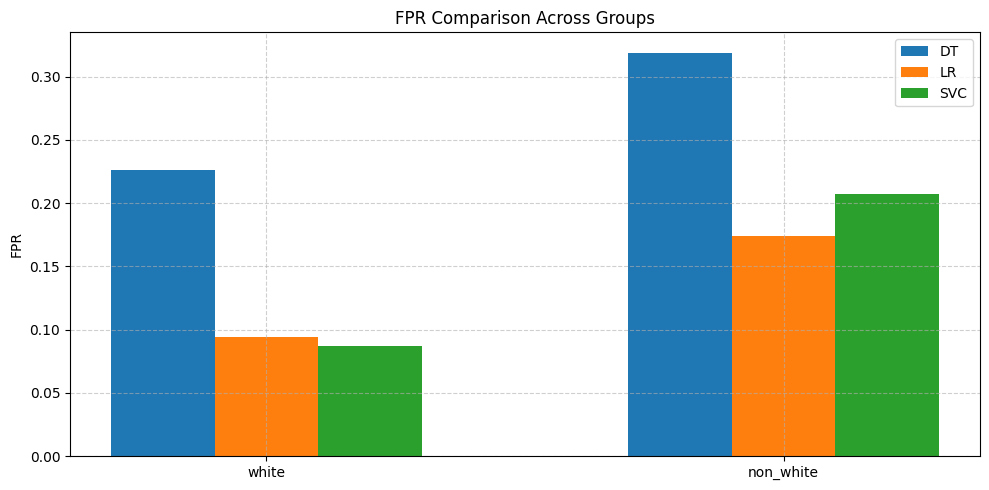

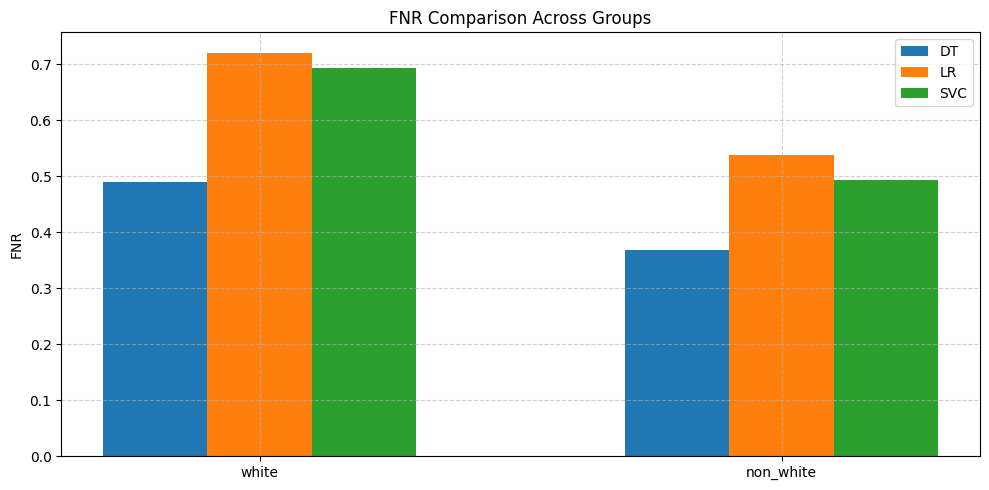

### Summary of Disparate Mistreatment Evaluation

,group,classifier,total_records,accuracy (%),error_rate (%),false_positive_rate (%),false_negative_rate (%)
0,white,dt,736,66.98,33.02,22.65,48.97
1,white,lr,736,65.90,34.10,9.42,72.07
2,white,svc,736,67.39,32.61,8.74,69.31
3,non_white,dt,1429,65.71,34.29,31.90,36.88
4,non_white,lr,1429,65.15,34.85,17.36,53.79
5,non_white,svc,1429,65.57,34.43,20.73,49.27


In [113]:
classifiers_result = evaluate_models_for_disparate_mistreatment(models)
summary_df = get_summary_of_disparate_mistreatment_evaluation(models, classifiers_result)
plot_disparate_mistreatment_summary(classifiers_result)
display(Markdown("### Summary of Disparate Mistreatment Evaluation"))
display(summary_df)

### 7.3.2 Mitigation via Post-Processing

To mitigate **disparate mistreatment**, we apply a post-processing technique using the `ThresholdOptimizer` from the `fairlearn` library. This approach adjusts the decision threshold of a pre-trained model to reduce disparities in error rates (FPR and FNR) between sensitive groups.

We specifically use:

* **Estimator**: A pre-trained classifier (e.g., logistic regression, decision tree, etc.)
* **Constraints**: `"equalized_odds"` to minimize both false positive rate and false negative rate differences between groups
* **Predict Method**: `"predict_proba"` to utilize probability scores
* **Prefit**: `True` indicating that the base model is already trained

This post-processing method does not retrain the model but optimizes its predictions to achieve fairer classification outcomes across sensitive groups.


#### 7.3.2.1 Train Fair Models

This step applies post-processing mitigation using ThresholdOptimizer with the Equalized Odds constraint to reduce FPR and FNR disparities across groups. Each trained model is wrapped and adjusted using the sensitive attribute.

In [114]:
fair_models = {}
for model_name, model in models.items():
  fair_model = ThresholdOptimizer(
      estimator= model,
      constraints="equalized_odds",  # minimizes disparity in both FPR and FNR
      predict_method="predict_proba",  # required for probability-based models
      prefit=True
  )
  fair_model.fit(x_train, y_train, sensitive_features=sensitive_train_group)
  fair_models[model_name] = fair_model

fair_models

{'dt': ThresholdOptimizer(constraints='equalized_odds',
                    estimator=DecisionTreeClassifier(max_depth=5,
                                                     random_state=0),
                    predict_method='predict_proba', prefit=True),
 'lr': ThresholdOptimizer(constraints='equalized_odds',
                    estimator=LogisticRegression(solver='liblinear'),
                    predict_method='predict_proba', prefit=True),
 'svc': ThresholdOptimizer(constraints='equalized_odds',
                    estimator=SVC(probability=True, random_state=42),
                    predict_method='predict_proba', prefit=True)}

#### 7.3.2.2 Evaluate and Visualize (Fair Models)

This section evaluates the fairness-mitigated models using the same metrics as before (accuracy, FPR, FNR, error), now with post-processing enabled. It summarizes and visualizes performance per sensitive group to assess improvements in disparate mistreatment.

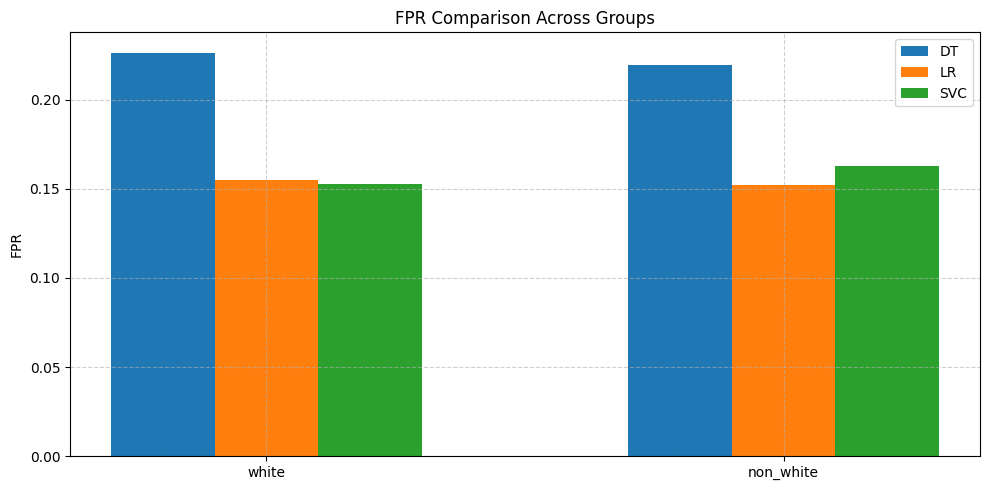

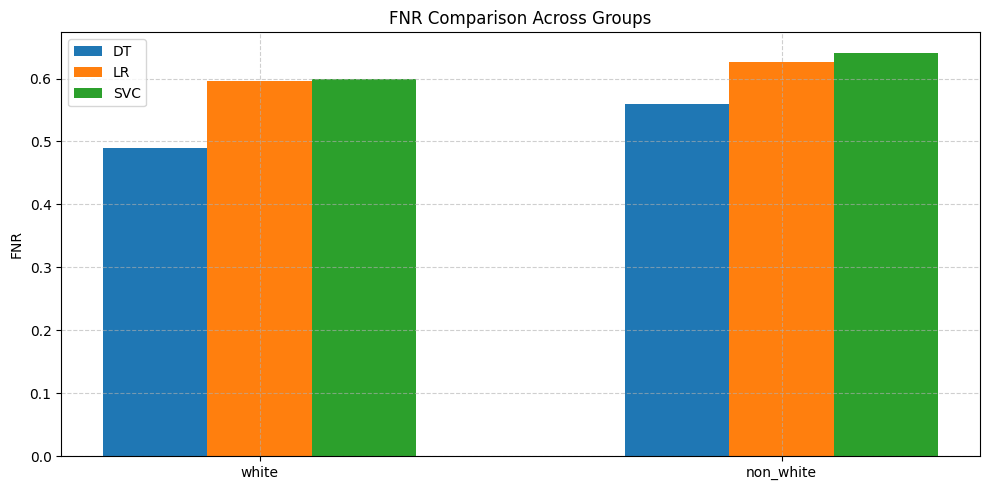

### Summary of Disparate Mistreatment Evaluation

,group,classifier,total_records,accuracy (%),error_rate (%),false_positive_rate (%),false_negative_rate (%)
0,white,dt,736,66.98,33.02,22.65,48.97
1,white,lr,736,67.12,32.88,15.47,59.66
2,white,svc,736,67.12,32.88,15.25,60.00
3,non_white,dt,1429,61.72,38.28,21.94,55.98
4,non_white,lr,1429,62.00,38.00,15.21,62.68
5,non_white,svc,1429,60.74,39.26,16.29,64.14


In [115]:
fair_classifiers_result = evaluate_models_for_disparate_mistreatment(fair_models, post_processing=True)
fair_summary_df = get_summary_of_disparate_mistreatment_evaluation(fair_models, fair_classifiers_result)
plot_disparate_mistreatment_summary(fair_classifiers_result)
display(Markdown("### Summary of Disparate Mistreatment Evaluation"))
display(fair_summary_df)

#### 7.3.2.3 Compare Disparate Mistreatment Before and After Mitigation

This code compares the fairness metrics of models before and after applying post-processing (via `ThresholdOptimizer`) to mitigate **disparate mistreatment**. It computes:

* **FPR Gap (Before/After)**: Absolute difference in false positive rates between white and non-white groups.
* **FNR Gap (Before/After)**: Absolute difference in false negative rates.
* **FPR/FNR Gap ↓**: Reduction in these gaps after mitigation.
* **Avg Accuracy (Before/After)**: Mean accuracy across groups before and after.
* **Accuracy ↓**: Any drop in average accuracy due to fairness optimization.

The resulting DataFrame helps assess how much fairness improved and at what accuracy cost.


In [116]:
pivot_fpr = summary_df.pivot(index="classifier", columns="group", values="false_positive_rate (%)")
pivot_fnr = summary_df.pivot(index="classifier", columns="group", values="false_negative_rate (%)")
pivot_acc = summary_df.pivot(index="classifier", columns="group", values="accuracy (%)")

pivot_fpr_fair = fair_summary_df.pivot(index="classifier", columns="group", values="false_positive_rate (%)")
pivot_fnr_fair = fair_summary_df.pivot(index="classifier", columns="group", values="false_negative_rate (%)")
pivot_acc_fair = fair_summary_df.pivot(index="classifier", columns="group", values="accuracy (%)")

# Calculate absolute gaps before and after
mistreatment_gap_df = pd.DataFrame()
mistreatment_gap_df["FPR Gap (Before)"] = abs(pivot_fpr["white"] - pivot_fpr["non_white"])
mistreatment_gap_df["FPR Gap (After)"] = abs(pivot_fpr_fair["white"] - pivot_fpr_fair["non_white"])
mistreatment_gap_df["FPR Gap ↓"] = (mistreatment_gap_df["FPR Gap (Before)"] - mistreatment_gap_df["FPR Gap (After)"]).round(2)

mistreatment_gap_df["FNR Gap (Before)"] = abs(pivot_fnr["white"] - pivot_fnr["non_white"])
mistreatment_gap_df["FNR Gap (After)"] = abs(pivot_fnr_fair["white"] - pivot_fnr_fair["non_white"])
mistreatment_gap_df["FNR Gap ↓"] = (mistreatment_gap_df["FNR Gap (Before)"] - mistreatment_gap_df["FNR Gap (After)"]).round(2)

# Optional: average accuracy change
mistreatment_gap_df["Avg Accuracy (Before)"] = pivot_acc.mean(axis=1)
mistreatment_gap_df["Avg Accuracy (After)"] = pivot_acc_fair.mean(axis=1)
mistreatment_gap_df["Accuracy ↓"] = (mistreatment_gap_df["Avg Accuracy (Before)"] - mistreatment_gap_df["Avg Accuracy (After)"]).round(2)

# Final display
mistreatment_gap_df = mistreatment_gap_df.round(2)
display(mistreatment_gap_df)


,FPR Gap (Before),FPR Gap (After),FPR Gap ↓,FNR Gap (Before),FNR Gap (After),FNR Gap ↓,Avg Accuracy (Before),Avg Accuracy (After),Accuracy ↓
classifier,,,,,,,,,
dt,9.25,0.71,8.54,12.09,7.01,5.08,66.34,64.35,2.00
lr,7.94,0.26,7.68,18.28,3.02,15.26,65.53,64.56,0.97
svc,11.99,1.04,10.95,20.04,4.14,15.90,66.48,63.93,2.55


This table illustrates the effectiveness of post-processing mitigation (via `ThresholdOptimizer`) in reducing disparate mistreatment specifically, gaps in false positive rate (FPR) and false negative rate (FNR) between white and non-white groups while also tracking the impact on average accuracy:

* **FPR Gap**:

  * All models show a dramatic reduction in FPR disparity.
  * `lr` reduced FPR gap from **7.94% to 0.26%**, the most efficient drop.
  * `dt` and `svc` also achieved large reductions (8.54% and 10.95%, respectively).

* **FNR Gap**:

  * FNR disparities were also greatly reduced, especially for `lr` (down from **18.28% to 3.02%** -> 15.26% decrease).
  * `svc` saw the largest raw FNR gap reduction (15.90%).

* **Accuracy**:

  * Fairness improvements came with minor accuracy losses, ranging from **0.97%** (`lr`) to **2.55%** (`svc`).
  * This is a reasonable trade-off given the substantial fairness gains.


Post-processing mitigation significantly improved fairness across all models, especially in reducing both FPR and FNR gaps with only a small decrease in average accuracy. Among the classifiers, Logistic Regression (lr) achieved the best fairness-accuracy trade-off.


# 8. Key Observations & Limitations

This project followed a clear and structured approach to evaluate and reduce three major types of algorithmic unfairness:

* **Disparate Treatment**
  - Checked by flipping the sensitive attribute (e.g., race) and observing prediction changes.
  - Mitigated by removing the sensitive feature during training.

* **Disparate Impact**
  - Focused on selection rate disparities between groups.
  - Addressed using reweighting before model training.

* **Disparate Mistreatment**
  - Measured differences in error rates (FPR/FNR) across groups.
  - Handled using post-processing via ThresholdOptimizer.

While this approach effectively targeted each bias type, there are key limitations:

* Fairness types were handled in isolation. No single model was built to optimize all three simultaneously.
* Only binary sensitive attributes were analyzed, which may miss intersectional biases (e.g., race × gender).
* The COMPAS dataset's label (1 = unfavorable outcome) required careful interpretation of fairness metrics.
* Accuracy–fairness trade-offs were observed.
* No cross-validation or hyperparameter tuning was applied, limiting generalizability.

Despite these, the project lays a solid groundwork for future research into more comprehensive fairness-aware modeling.


# 9. Future Work

To build upon this foundation, future work could explore:

* **Unified Fairness Modeling**: Develop and evaluate models that address all three types of discrimination (treatment, impact, and mistreatment) simultaneously rather than separately.
* **Intersectional Fairness**: Extend the analysis to handle multi-attribute sensitive groups (e.g., race x gender) to uncover deeper and overlapping biases.
* **Hyperparameter Tuning & Cross-Validation**: Apply techniques like grid search and k-fold cross-validation to improve both fairness and generalizability of the models.
* **Trade-off Analysis**: Systematically explore the balance between model accuracy and fairness to better inform practical deployment decisions.


# 10. Conclusion

This project successfully identified and mitigated three major types of algorithmic bias such as **disparate treatment**, **disparate impact**, and **disparate mistreatment** using targeted techniques such as feature exclusion, reweighting, and post-processing. The results show that fairness can be improved with minimal impact on accuracy, paving the way for more responsible AI systems.